In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.applications import *
from tensorflow.keras.models import Sequential, Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
import os

In [ ]:
img_height = 224
img_width = 224

train_ds = tf.keras.utils.image_dataset_from_directory(
  '/kaggle/input/solar-panel-images/Faulty_solar_panel',
  validation_split=0.2,
  subset='training',
  seed=100,
  image_size=(img_height, img_width),
  batch_size=32,
  shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  '/kaggle/input/solar-panel-images/Faulty_solar_panel',
  validation_split=0.2,
  subset='validation',
  seed=200,
  image_size=(img_height, img_width),
  batch_size=32,
  shuffle=True
)

train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

Found 885 files belonging to 6 classes.
Using 708 files for training.
Found 885 files belonging to 6 classes.
Using 177 files for validation.


In [ ]:
data_dir = '/kaggle/input/solar-panel-images/Faulty_solar_panel'
class_names = sorted(entry.name for entry in os.scandir(data_dir) if entry.is_dir())
print(class_names)

['Bird-drop', 'Clean', 'Dusty', 'Electrical-damage', 'Physical-Damage', 'Snow-Covered']


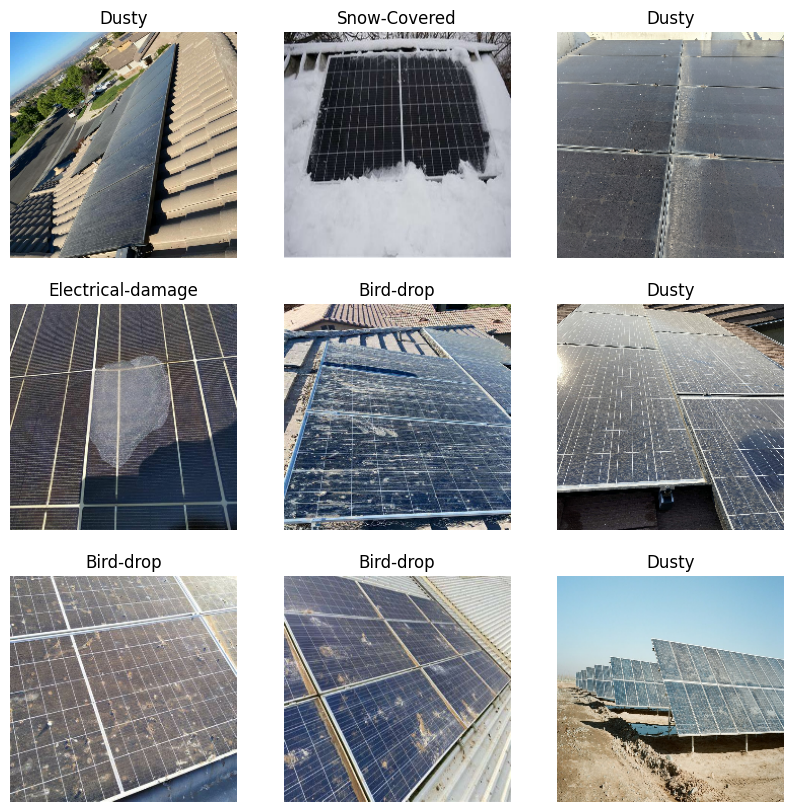

In [ ]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

base_model.trainable = False

resnet_model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(6, activation='softmax')
])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

In [ ]:
resnet_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │        12,294 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,600,006 (90.03 MB)

 Trainable params: 12,294 (48.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
resnet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = resnet_model.fit(train_ds, epochs=30, validation_data=val_ds, callbacks=[early_stopping, reduce_lr])

Epoch 1/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 26s 565ms/step - accuracy: 0.2849 - loss: 2.4175 - val_accuracy: 0.5876 - val_loss: 1.1267 - learning_rate: 0.0010
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 197ms/step - accuracy: 0.4955 - loss: 1.4874 - val_accuracy: 0.7401 - val_loss: 0.7947 - learning_rate: 0.0010
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 192ms/step - accuracy: 0.6140 - loss: 1.1420 - val_accuracy: 0.7571 - val_loss: 0.6852 - learning_rate: 0.0010
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 227ms/step - accuracy: 0.6811 - loss: 0.9047 - val_accuracy: 0.8136 - val_loss: 0.5744 - learning_rate: 0.0010
Epoch 5/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 193ms/step - accuracy: 0.6982 - loss: 0.8779 - val_accuracy: 0.8079 - val_loss: 0.5221 - learning_rate: 0.0010
Epoch 6/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 180ms/step - accuracy: 0.7235 - loss: 0.7082 - val_accuracy: 0.8079 - val_loss: 0.5283 - learning_rate: 0.0010
Epoch 7/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 192ms/step - accuracy: 0.7457 - loss: 0.7113 -

In [ ]:
loss, acc = resnet_model.evaluate(val_ds)
print('Test accuracy:', acc)
print('Test loss:', loss)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - accuracy: 0.9425 - loss: 0.2669
Test accuracy: 0.9548022747039795
Test loss: 0.2521677315235138


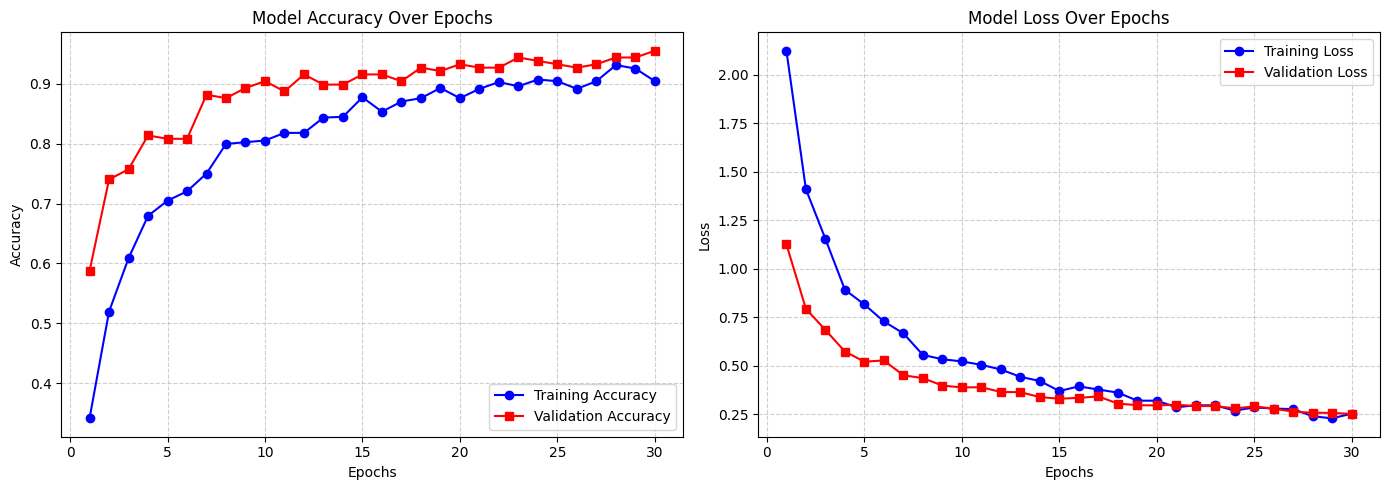

In [ ]:
epochs = range(1, len(history.history['accuracy']) + 1)
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], 'b-o', label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], 'r-s', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], 'b-o', label='Training Loss')
plt.plot(epochs, history.history['val_loss'], 'r-s', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss Over Epochs')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [ ]:
y_val = []
y_pred = []

for images, labels in val_ds:
    preds = resnet_model.predict(images)
    preds = tf.argmax(preds, axis=1)
    y_pred.extend(preds.numpy())
    y_val.extend(labels.numpy())

print(classification_report(y_val, y_pred, digits=4))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
              precision    recall  f1-score   support

           0     0.9574    0.9375    0.9474        48
           1     0.9500    0.9500    0.9500        40
           2     0.9286    0.8966    0.9123        29
           3     0.9524    1.0000    0.9756        20
           4     0.9286    1.0000    0.9630        13
           5     1.0000    1.0000    1.0000        27

    accuracy                         0.9548       177
   macro avg     0.9528    0.9640    0.9580       177
weighted avg     0.9548    0.9548    0.9546       177



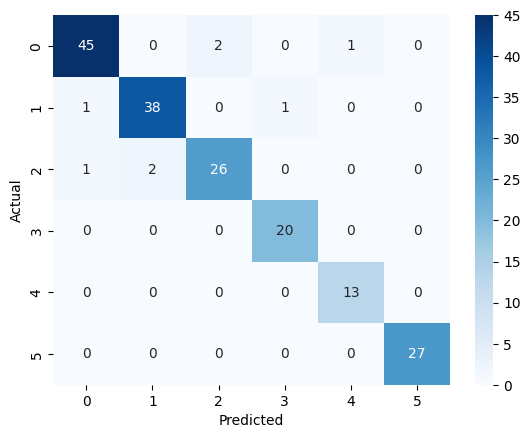

In [ ]:
conf_matrix = confusion_matrix(y_val, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()